### Linear Regression of Airbnb Room Data

In [19]:
# Imports
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import numpy as np
from sklearn_pandas import DataFrameMapper
# import statsmodels.formula.api as smf
import pandas as pd

In [20]:
def print_scores(model, xtrain, ytrain, xtest, ytest):
    """Prints scores for a model with training, and test data splits."""
    print('Train R2', round(model.score(xtrain, ytrain), 3))
    print('Test R2', round(model.score(xtest, ytest), 3))
    return None

In [21]:
def print_root_mean_err(true, pred):
    print('RMSError = ${}'.format(round(np.sqrt(mean_squared_error(true, pred)), 2)))
    return None

In [22]:
def replace_zeroes(series):
    new_series = pd.Series(index=series.index)
    for idx, item in series.iteritems():
        new_series[idx] = 1 if item == 0 else item
    return new_series

In [38]:
# Read in room data
rooms = pd.read_csv('../data/bogota-clean-10-06-2019--20-16-39.csv')
rooms['cleaning_fee'] = replace_zeroes(rooms.cleaning_fee)
rooms['beds'] = replace_zeroes(rooms.beds)

In [39]:
# Set target variable and features array. The target is the price of the room.
y = rooms.price
X = rooms[['guests', 'bedrooms', 'beds', 'baths', 'cleaning_fee',
           'amenities', 'superhost', 'narrative', 'rules']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

In [40]:
# Fit training data and attempt to predict test data.
lr = LinearRegression(n_jobs=10, copy_X=True)
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

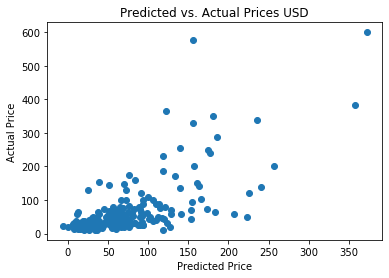

In [41]:
# Plot predicted values vs. actual values.
plt.title('Predicted vs. Actual Prices USD')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.scatter(y_predict, y_test);

Residuals are y_test - y_predict

Display the $R^2\; score$ for the predicted values.

In [42]:
# r^2 scores
print_scores(lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, y_predict)

Train R2 0.457
Test R2 0.471
RMSError = $59.89


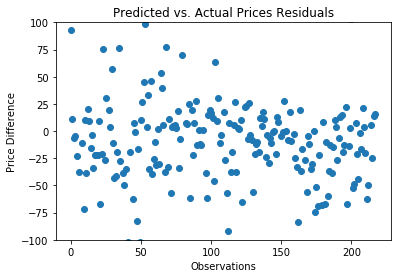

In [43]:
# x_vals is for plotting residuals
x_vals = np.arange(0, y_test.shape[0], 1)
plt.scatter(x_vals, y_test - y_predict)
plt.ylim(-100, 100)
plt.title('Predicted vs. Actual Prices Residuals')
plt.xlabel('Observations')
plt.ylabel('Price Difference');

#### Since Linear Regression didn't perform that great we will try applying some transforms

In [44]:
# Rerun the regression with transforms
pipe = make_pipeline(StandardScaler(), LinearRegression(copy_X=True))
pipe.fit(X_train, y_train)
y_scaled_predict = pipe.predict(X_test)

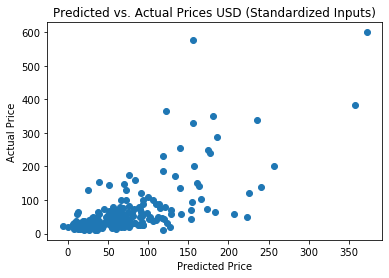

In [45]:
# Plot predicted values vs. actual values.
plt.title('Predicted vs. Actual Prices USD (Standardized Inputs)')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.scatter(y_scaled_predict, y_test);

In [46]:
print_scores(pipe, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, y_scaled_predict)

Train R2 0.457
Test R2 0.471
RMSError = $59.89


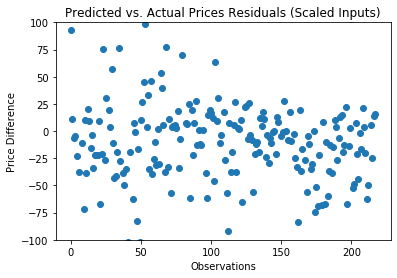

In [47]:
# x_vals is for plotting residuals
x_vals = np.arange(0, y_test.shape[0], 1)
plt.scatter(x_vals, y_test - y_scaled_predict)
plt.ylim(-100, 100)
plt.title('Predicted vs. Actual Prices Residuals (Scaled Inputs)')
plt.xlabel('Observations')
plt.ylabel('Price Difference');

#### Try taking the log of several features to see if that improves performance of the model. Need to improve upon $RMSError = \$59.89$

In [48]:
log_and_std = make_pipeline(FunctionTransformer(np.log, validate=True) , StandardScaler())
maptf = DataFrameMapper([
    (['guests', 'bedrooms', 'cleaning_fee'], log_and_std),
    (['baths', 'beds', 'amenities', 'superhost', 'narrative', 'rules'], StandardScaler())
])
mapped_lr = make_pipeline(maptf, LinearRegression(copy_X=True))
mapped_lr.fit(X_train, y_train)
print_scores(mapped_lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, mapped_lr.predict(X_test))

Train R2 0.455
Test R2 0.456
RMSError = $60.73


In [49]:
log_and_std = make_pipeline(FunctionTransformer(np.log, validate=True) , StandardScaler())
maptf = DataFrameMapper([
    (['guests', 'bedrooms', 'beds'], log_and_std),
    (['baths', 'cleaning_fee', 'amenities', 'superhost', 'narrative', 'rules'], StandardScaler())
])
mapped_lr = make_pipeline(maptf, LinearRegression(copy_X=True))
mapped_lr.fit(X_train, y_train)
print_scores(mapped_lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, mapped_lr.predict(X_test))

Train R2 0.458
Test R2 0.467
RMSError = $60.11


In [52]:
log_and_std = make_pipeline(FunctionTransformer(np.log, validate=True) , StandardScaler())
maptf = DataFrameMapper([
    (['guests', 'beds', 'bedrooms', 'baths'], log_and_std),
    (['amenities', 'superhost', 'narrative', 'rules'], StandardScaler())
])
mapped_lr = make_pipeline(maptf, LinearRegression(copy_X=True))
mapped_lr.fit(X_train, y_train)
print_scores(mapped_lr, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, mapped_lr.predict(X_test))

Train R2 0.397
Test R2 0.353
RMSError = $66.21


In [ ]:
def optimize_log():
    log_and_std = make_pipeline(FunctionTransformer(np.log, validate=True) , StandardScaler())
    maptf = DataFrameMapper([
        (['guests', 'beds', 'bedrooms', 'baths'], log_and_std),
        (['amenities', 'superhost', 'narrative', 'rules'], StandardScaler())
    ])
    mapped_lr = make_pipeline(maptf, LinearRegression(copy_X=True))
    mapped_lr.fit(X_train, y_train)
    print_scores(mapped_lr, X_train, y_train, X_test, y_test)
    print_root_mean_err(y_test, mapped_lr.predict(X_test))

#### Scaling inputs didn't make much difference. Trying adding Polynomial Effects

In [ ]:
pipe2 = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression(copy_X=True))
pipe2.fit(X_train, y_train)
y2_predict = pipe2.predict(X_test)

In [ ]:
# Plot predicted values vs. actual values.
plt.title('Predicted vs. Actual Prices USD (Standardized Inputs)')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.scatter(y2_predict, y_test);

In [ ]:
print_scores(pipe2, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, y2_predict)

#### Looks like overfitting is taking place. Going to try some regularization.

In [53]:
# Base Lasso 
ls = LassoCV(cv=5, copy_X=True)
ls.fit(X_train, y_train)
ls_y_predict = ls.predict(X_test)
print_scores(ls, X_train, y_train, X_test, y_test)
print_root_mean_err(y_test, ls_y_predict)

Train R2 0.456
Test R2 0.472
RMSError = $59.81


In [105]:
test_alphas = np.arange(1, 10, 0.25)
r_squares_train = []
r_squares_test = []
for i in test_alphas:
    ls_pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), 
                            LassoCV(cv=5, copy_X=True, max_iter=1000, alphas=[i], random_state=42))
    ls_pipe.fit(X_train, y_train)
    ls_pipe_y_predicted = ls.predict(X_test)
    r_squares_train.append(ls_pipe.score(X_train, y_train))
    r_squares_test.append(ls_pipe.score(X_test, y_test))
    

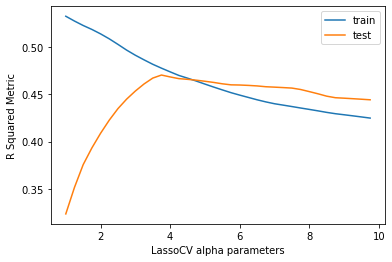

In [110]:
plt.plot(test_alphas, r_squares_train)
plt.plot(test_alphas, r_squares_test)
plt.legend(['train', 'test'])
plt.ylabel('R Squared Metric')
plt.xlabel('LassoCV alpha parameters');

In [ ]:
cv_pipe = make_pipeline(StandardScaler(), LinearRegression(normalize=True, n_jobs=100, copy_X=True))
cross_val_score(cv_pipe, X, y, cv=5)

In [ ]:
cross_val_score(LinearRegression(normalize=False, copy_X=True), X, y, cv=5)

In [ ]:
def cvs(x_data, y_data, states, norm=False):
    cvs_lr = LinearRegression(normalize=norm, copy_X=True)
    scores = []
    for state in states:
        cvs_X_train, cvs_X_test, cvs_y_train, cvs_y_test = train_test_split(X, y, shuffle=True, random_state=state)
        cvs_lr.fit(cvs_X_train, cvs_y_train)
        scores.append(((cvs_lr.score(cvs_X_train, cvs_y_train)), cvs_lr.score(cvs_X_test, cvs_y_test)))
    return scores
cvs(X, y, range(0, 500, 100))

In [ ]:
cvs(X, y, range(0, 500, 100), norm=True)